In [1]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.sparse import hstack

file_path = "/Users/jessedimarzo/Downloads/Resume.csv"

resume_data = pd.read_csv(file_path)

resume_data.head(5)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert text to lowercase, remove special characters, numbers, and punctuation, 
# remove extra whitespace, using the built in python library re.

In [3]:
resume_data['Cleaned_Resume_str'] = resume_data['Resume_str'].apply(clean_text)
# Apply the created cleaning function to the Resume_str column in the dataset

In [4]:
print(resume_data['ID'].is_unique)
# Just to confirm that the ID is a unique identifier, which the output of "True" confirmed. 
# The ID column is unnecessary for the analysis and modeling we will be performing, 
# and thus will be removed at this stage in the cleaning process.

True


In [5]:
# Drop the ID column as stated
resume_data = resume_data.drop(columns=['ID'])

# To confirm the column is removed
print(resume_data.head())

                                          Resume_str  \
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1           HR SPECIALIST, US HR OPERATIONS      ...   
2           HR DIRECTOR       Summary      Over 2...   
3           HR SPECIALIST       Summary    Dedica...   
4           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  \
0  <div class="fontsize fontface vmargins hmargin...       HR   
1  <div class="fontsize fontface vmargins hmargin...       HR   
2  <div class="fontsize fontface vmargins hmargin...       HR   
3  <div class="fontsize fontface vmargins hmargin...       HR   
4  <div class="fontsize fontface vmargins hmargin...       HR   

                                  Cleaned_Resume_str  
0  hr administratormarketing associate hr adminis...  
1  hr specialist us hr operations summary versati...  
2  hr director summary over years experience in r...  
3  hr specialist summary dedicated driven and dyn...

# Exploratory Data Analysis (EDA)

In [6]:
category_counts = resume_data['Category'].value_counts()
print(category_counts)

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


The above code provides the count of each job category present in the dataset. The purpose of this is to check for imbalances in the data, as this could lead to biased classification models, which could perform poorly on underrepresented categories.

From the output, the top categories are INFORMATION-TECHNOLOGY and BUSINESS-DEVELOPMENT, both containing 120 resumes. Many of the other categories are right below 120, with the top 15 categories(by count) all within 10 resumes of the top two.

There are a few underrepresented categories, specifically in AGRICULTURE (63 resumes), AUTOMOBILE (36 resumes), and BPO (22 resumes). Clearly, there is a significant imbalance in these categories compared to the others, which could affect classification model performance. To combat this class imbalance, techniques such as stratified train-test splits will ensure that all categories are represented proportionally.

The imbalances are shown in the following bar charts:

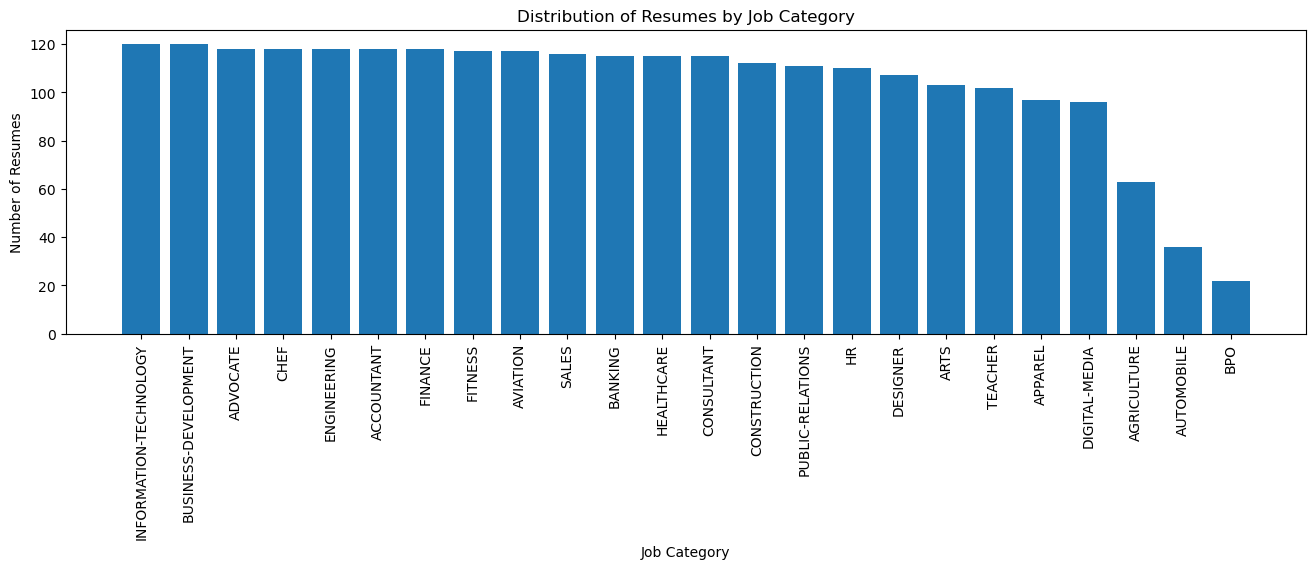

In [7]:
plt.figure(figsize=(16, 8))
plt.bar(category_counts.index, category_counts.values)
plt.title('Distribution of Resumes by Job Category')
plt.xlabel('Job Category')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5)
plt.show()

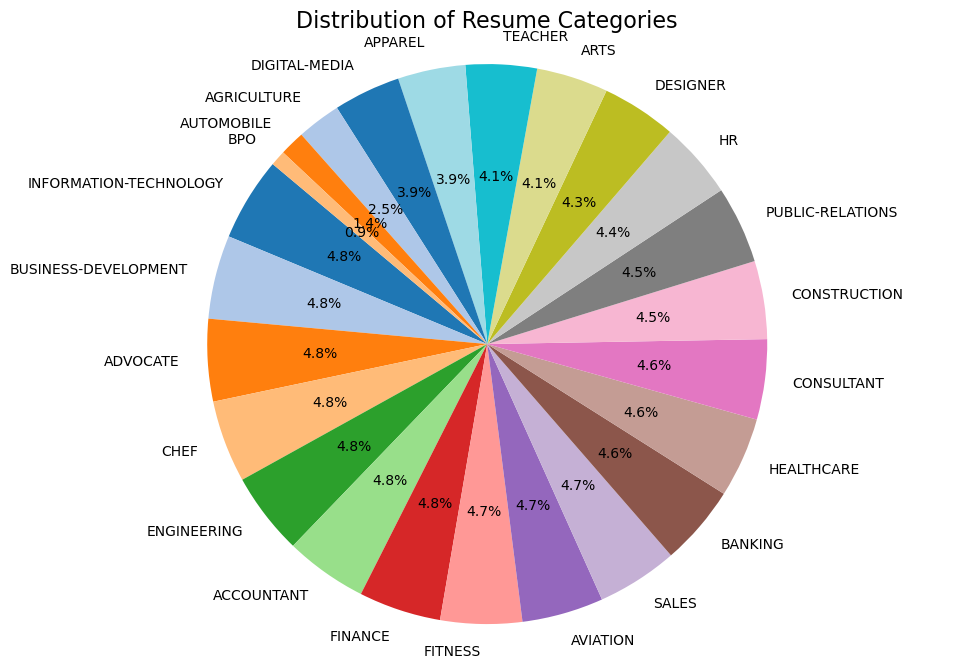

In [8]:
plt.figure(figsize=(12, 8))
category_counts = resume_data['Category'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Distribution of Resume Categories', fontsize=16)
plt.axis('equal')
plt.show()

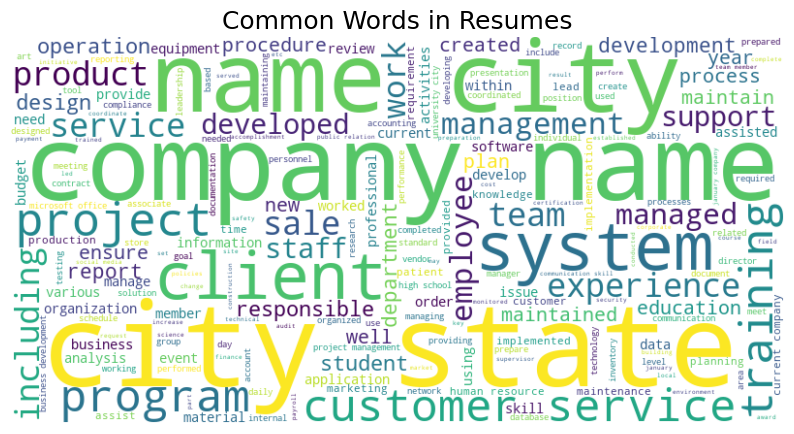

In [9]:
text_data = " ".join(resume_data['Cleaned_Resume_str'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Resumes', fontsize=18)
plt.show()

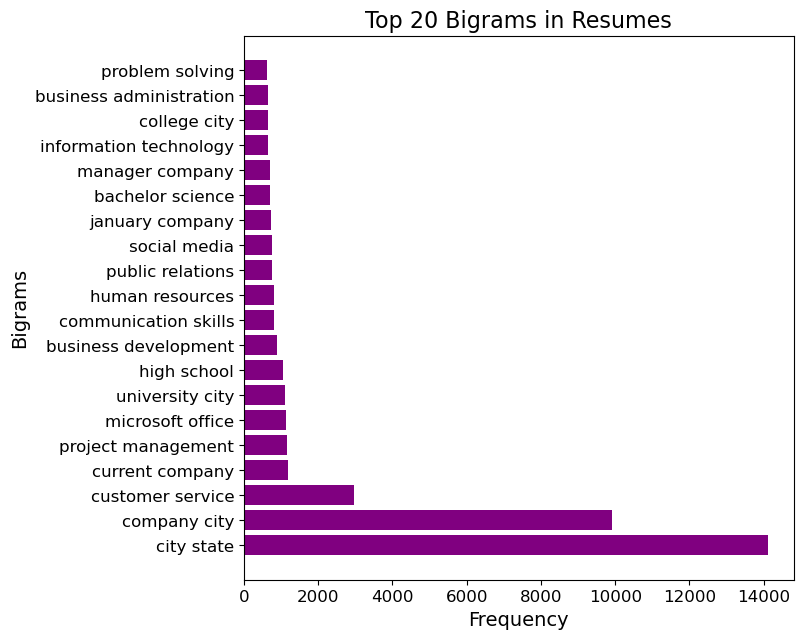

In [10]:
# Generate bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
bigrams = vectorizer.fit_transform(resume_data['Cleaned_Resume_str'])

# Get bigram frequencies
bigram_df = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'count': bigrams.sum(axis=0).A1
}).sort_values(by='count', ascending=False)

# Extract bigram labels and frequencies
bigram_labels = bigram_df['bigram']
bigram_freq = bigram_df['count']

# Plot the bigram frequencies
plt.figure(figsize=(10, 8))
plt.barh(bigram_labels, bigram_freq, color="purple")
plt.title("Top 20 Bigrams in Resumes", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Bigrams", fontsize=14)

plt.subplots_adjust(left=0.35)
plt.subplots_adjust(bottom=0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

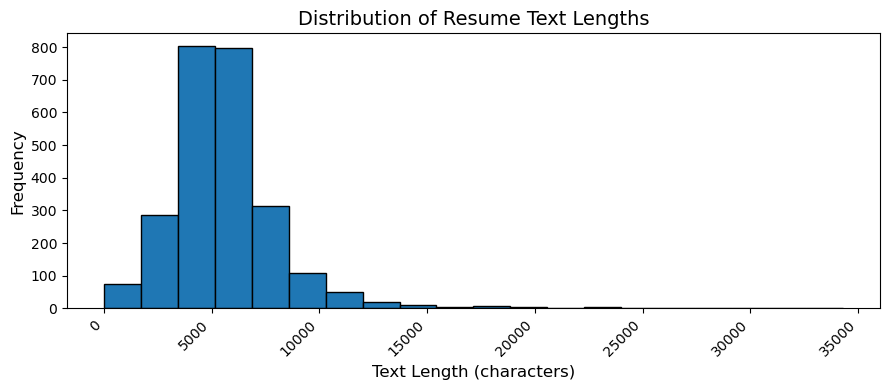

In [11]:
resume_data['Text_Length'] = resume_data['Cleaned_Resume_str'].apply(len)

plt.figure(figsize=(9, 4))
plt.hist(resume_data['Text_Length'], bins=20, edgecolor='black')
plt.title('Distribution of Resume Text Lengths', fontsize=14)
plt.xlabel('Text Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

The above code aids in examining variability in the length of resumes. It appears that visually, the distribution of resume text lengths is approximately normal, although there may be extreme outliers as seen in the 25000 and 35000 character length resumes. This is just another part of the EDA, to gain a better understanding of the resumes as a whole.


In [12]:
it_resumes = resume_data[resume_data['Category'] == 'INFORMATION-TECHNOLOGY']
common_words = Counter(" ".join(it_resumes['Cleaned_Resume_str']).split()).most_common(20)
print(common_words)

[('and', 6827), ('to', 2767), ('of', 2329), ('the', 2319), ('for', 1520), ('in', 1210), ('with', 977), ('management', 890), ('a', 876), ('information', 854), ('technology', 735), ('systems', 734), ('support', 666), ('network', 656), ('state', 636), ('company', 617), ('city', 613), ('system', 577), ('project', 557), ('data', 543)]


In [13]:
aviation_resumes = resume_data[resume_data['Category'] == 'BPO']
common_words1 = Counter(" ".join(aviation_resumes['Cleaned_Resume_str']).split()).most_common(30)
print(common_words1)

[('and', 1097), ('to', 555), ('the', 533), ('of', 509), ('for', 361), ('in', 358), ('with', 221), ('a', 212), ('management', 202), ('company', 125), ('team', 124), ('on', 123), ('as', 116), ('city', 116), ('name', 115), ('business', 107), ('state', 105), ('process', 98), ('client', 95), ('customer', 87), ('service', 84), ('by', 82), ('sales', 79), ('support', 75), ('operations', 73), ('all', 73), ('new', 71), ('that', 67), ('network', 66), ('training', 63)]


In [14]:
aviation_resumes = resume_data[resume_data['Category'] == 'AVIATION']
common_words2 = Counter(" ".join(aviation_resumes['Cleaned_Resume_str']).split()).most_common(30)
print(common_words2)

[('and', 5758), ('to', 2345), ('of', 2069), ('the', 1670), ('for', 1176), ('in', 1146), ('with', 823), ('a', 724), ('state', 641), ('city', 604), ('on', 534), ('as', 523), ('company', 521), ('management', 519), ('training', 472), ('aviation', 462), ('name', 440), ('all', 392), ('maintenance', 388), ('aircraft', 356), ('systems', 342), ('skills', 333), ('customer', 319), ('equipment', 312), ('safety', 311), ('i', 285), ('or', 281), ('by', 277), ('work', 269), ('experience', 268)]


The counter package from the collections library is quite useful to see the most frequent words in each category. By doing so, we get a general idea of which words may be distinct between categories. For example, in INFORMATION-TECHNOLOGY, we see that technology, systems, and network are extremely frequent words, and in AVIATION, aircraft, state, city are very common. While this step provides insights into distinctions between categories, it reveals some issues that may arise for the machine learning. These two categories are vastly different, yet 'management' and 'system' are highly used in both, potentially exposing opportunity for confusion between the two categories.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to Generate BERT Embeddings
def get_bert_embeddings_batch(texts, tokenizer, model, max_length=512):
    """
    Generate BERT embeddings for a batch of texts.
    """
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, max_length=max_length, 
                       padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
    return embeddings

# Save embeddings in batches because my kernel kept crashing
batch_size = 32
num_batches = len(resume_data) // batch_size + (len(resume_data) % batch_size > 0)

print("Generating BERT embeddings in batches...")
for i in tqdm(range(num_batches), desc="Processing Batches"):
    batch_texts = resume_data['Cleaned_Resume_str'][i * batch_size:(i + 1) * batch_size].tolist()
    batch_embeddings = get_bert_embeddings_batch(batch_texts, tokenizer, model)
    
    # Save each batch as a NumPy file since I was losing the embeddings from kernel crashing
    np.save(f"bert_embeddings_batch_{i}.npy", batch_embeddings)

# Save labels separately
resume_data[['Category']].to_csv("resume_labels.csv", index=False)
print("Embeddings and labels saved in batches successfully.")

In [15]:
batch_files = sorted([f for f in os.listdir('.') if f.startswith("bert_embeddings_batch_") and f.endswith(".npy")])

embeddings = []
for file in batch_files:
    batch = np.load(file)
    embeddings.append(batch)

bert_embeddings = np.vstack(embeddings)

labels = pd.read_csv("resume_labels.csv")
y = labels['Category']

print("Loaded embeddings and labels successfully.")

Loaded embeddings and labels successfully.


This project was more intensive than I thought initially, and it took a lot of stackoverflow and online information to introduce embeddings successfully. The above code basically loads the saved batches, a ton of them, and combines them into a single NumPy array. The labels are separately loaded in a different file. Each time I generated the embeddings, my kernel would crash when it reached 100%, indicated by the tqsm progress bar, thus I had to create them in batches as per recommendation on stackoverflow.

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(resume_data['Cleaned_Resume_str'])

In [17]:
# Combine TF-IDF features with BERT embeddings
combined_features = hstack([tfidf_matrix, bert_embeddings])

In [18]:
# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, y_encoded, test_size=0.2, stratify=y_encoded, random_state=4188
)

In [19]:
xgb_model = XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.05, random_state=4188)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.8209255533199196

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.85        24
           1       0.79      0.92      0.85        24
           2       0.70      0.54      0.61        13
           3       0.85      0.58      0.69        19
           4       0.78      0.67      0.72        21
           5       1.00      0.57      0.73         7
           6       0.83      0.83      0.83        23
           7       0.87      0.57      0.68        23
           8       1.00      0.25      0.40         4
           9       0.91      0.88      0.89        24
          10       1.00      0.96      0.98        24
          11       0.83      0.91      0.87        22
          12       0.69      0.78      0.73        23
          13       0.78      1.00      0.88        21
          14       0.76      0.68      0.72        19
          15       0.81      0.88      0.84        24
          16       

In [20]:
category_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

for category_number, category_name in category_mapping.items():
    print(f"Category {category_number}: {category_name}")

Category 0: ACCOUNTANT
Category 1: ADVOCATE
Category 2: AGRICULTURE
Category 3: APPAREL
Category 4: ARTS
Category 5: AUTOMOBILE
Category 6: AVIATION
Category 7: BANKING
Category 8: BPO
Category 9: BUSINESS-DEVELOPMENT
Category 10: CHEF
Category 11: CONSTRUCTION
Category 12: CONSULTANT
Category 13: DESIGNER
Category 14: DIGITAL-MEDIA
Category 15: ENGINEERING
Category 16: FINANCE
Category 17: FITNESS
Category 18: HEALTHCARE
Category 19: HR
Category 20: INFORMATION-TECHNOLOGY
Category 21: PUBLIC-RELATIONS
Category 22: SALES
Category 23: TEACHER


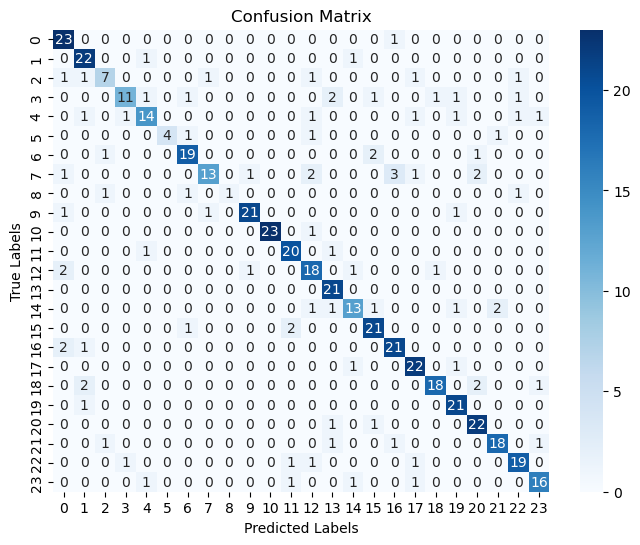

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()